In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix,print_matrix
from scripts_tempHelix import generate_static_temporal_helix
from scripts_theoreticalHittingTime import create_transition_matrix,expected_hitting_time

In [2]:
def estimate_hitting_time(reps, start_vertex, end_vertex, num_simulations=10):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for rep in range(1,reps):
        print(f'\nCalculatig hitting time for reps = {rep} ; n = {3+3*rep}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = nx.from_numpy_array(generate_static_temporal_helix(rep))
        current_node = list(graph.nodes)[start_vertex]
        end_node = list(graph.nodes)[end_vertex]
        print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s==0 or s==1 or s==10 or s==25 or s==35 or s==49 or s==59 or s==69 or s==79 or s==89 or s==99:
                print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps_this_simulation += 1
                # print(current_node)
                # print(end_node)
                # print()

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times

def fit_hitting_time(n,factor,c):
    hitting_times = []
    for i in n:
        hitting_times.append(c*i**factor)
       
    return hitting_times

In [16]:
reps = 30

sum_range = []
samples = 500

sum_range = [3 + 3*rep for rep in range(1,reps)]
print(sum_range)

initVertex = 0
targetVertex = -1

factor = 2
c = 1

hitting_times_file = f'Datasets/DynGraphsDTRW/hittingTimeStaticTempHelix_N{sum_range[-1]}_FROM{initVertex}-TO{targetVertex}_S{samples}.txt'
hitting_times = estimate_hitting_time(reps,initVertex,targetVertex,samples)

# print(f'Looking for: \n-----> {hitting_times_file}')

# if os.path.exists(hitting_times_file):
#     hitting_times = load_list_from_file(hitting_times_file)
#     fit_hitting_times = fit_hitting_time(sum_range,factor,c)
#     print('\nFile exists!')
# else:
#     print('\nFile Doesnt Exist!')
#     hitting_times = estimate_hitting_time(reps,initVertex,targetVertex,samples)
#     fit_hitting_times = fit_hitting_time(sum_range,factor,c)

#     write_list_to_file(hitting_times_file, hitting_times)



[6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90]

Calculatig hitting time for reps = 1 ; n = 6
Starting node: 0 	 Neighbors: [0, 1]
End node: 5 	 Neighbors: [4, 5]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 2 ; n = 9
Starting node: 0 	 Neighbors: [0, 1]
End node: 8 	 Neighbors: [7, 8]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 3 ; n = 12
Starting node: 0 	 Neighbors: [0, 1]
End node: 11 	 Neighbors: [10, 11]
----> Sample number:0
----> Sample

In [39]:
def theoretical_hitting_time(P, init, target):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    # print(n)
    
    if target=='mid':
        target = n//2
        
    if target=='-1':
        target = n-1
        
    order = list(range(n))
    order.remove(target)
    order.append(target)
    
    P = P[np.ix_(order, order)]
    # print_matrix(P)
    # print()
        
    P_prime = P[:-1, :-1]

    init_dist = np.zeros(n-1)
    init_dist[init] = 1
    
    target_dist = np.ones(n-1)

    I = np.eye(n-1)

    P_prime_inv = np.linalg.inv(I - P_prime)
        
    hitting_time = np.dot(init_dist, np.dot(P_prime_inv, target_dist))

    return hitting_time

def theoretical_hitting_times_for_staticTempHelix_graphs(reps, init, target):
    hitting_times = []
    for rep in range(1,reps):
            G = nx.from_numpy_array(generate_static_temporal_helix(rep))
            P = create_transition_matrix(G)
            hitting_time = theoretical_hitting_time(P, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

# G = nx.from_numpy_array(generate_static_temporal_helix(rep))
# P = create_transition_matrix(G)
# hitting_time = theoretical_hitting_time5(P, init, target,steps)

In [40]:
reps = 30

init = 0
target = '-1'

sum_range = [3 + 3*rep for rep in range(1,reps)]

theoretical_hitting_times =  theoretical_hitting_times_for_staticTempHelix_graphs(reps, init, target)

# theoretical_hitting_times_file5 = f'Datasets/DynGraphsDTRW/theoreticalHitting6TimeStaticTempHelix_N{sum_range[-1]}_FROM{initVertex}-TO{targetVertex}_STEPS{steps}.txt'

# print(f'Looking for: \n-----> {theoretical_hitting_times_file5}')

# if os.path.exists(theoretical_hitting_times_file5):
#     theoretical_hitting_times5 = load_list_from_file(theoretical_hitting_times_file5)
#     print('\nFile exists!')
# else:
#     print('\nFile Doesnt Exist!')
#     theoretical_hitting_times5 =  theoretical_hitting_times5_for_staticTempHelix_graphs(reps, init, target,steps)
#     write_list_to_file(theoretical_hitting_times_file5, theoretical_hitting_times5)

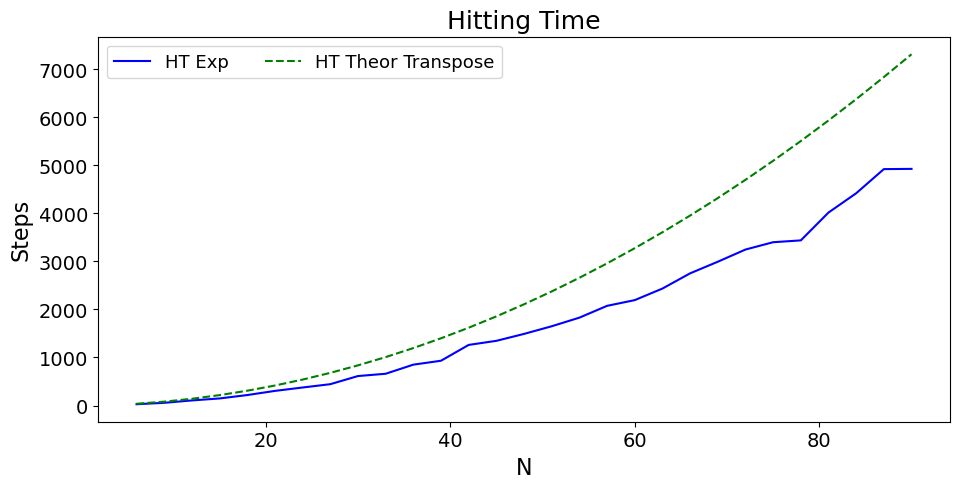

In [41]:
alphaLabelList = [r'HT Exp',f'HT Theor Transpose']# ,f'HT TheorV1 Szeg',f'HT TheorV4 Kr',f'HT TheorV5 Kr',f'n^2',f'{round(c,2)}n^{factor}']


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 2,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
}

y_value_list = [hitting_times,
                theoretical_hitting_times]

plot_qwak(x_value_matrix = [list(sum_range)]*len(y_value_list) , y_value_matrix = y_value_list ,**params)